In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler

In [86]:
#Load dataset and insert column names, remove the semicolon
column_names= ["user_id", "activity", "timestamp", "axis_x", "axis_y", "axis_z"]
data = pd.read_csv("Dataset/WISDM_ar_v1.1_raw.txt", header=None, names=column_names, comment=";")

In [87]:
data.head()

,user_id,activity,timestamp,axis_x,axis_y,axis_z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [88]:
#Plot accelerometer data
activity = "Jogging"
axis_x = data[data['activity'] == activity][['axis_x']][:150]
axis_y = data[data['activity'] == activity][['axis_y']][:150]
axis_z = data[data['activity'] == activity][['axis_z']][:150]

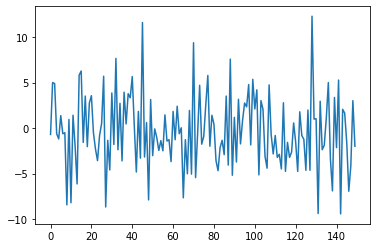

In [89]:
plt.plot(axis_x)

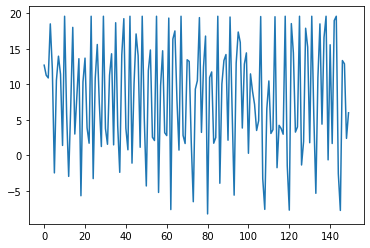

In [90]:
plt.plot(axis_y)

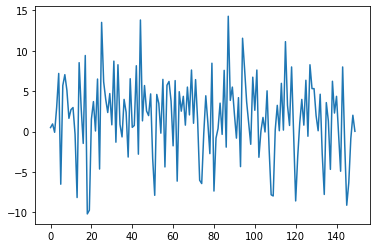

In [91]:
plt.plot(axis_z)

In [92]:
#How many different persons (id´s) in data
unique_id = data.user_id.unique()
unique_id_sorted = np.sort(unique_id)
print(unique_id_sorted)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


In [93]:
#How many different activities
unique_activity = data.activity.unique()
print(unique_activity)
activity_dict = {1:"Jogging", 2:"Walking", 3:"Upstairs", 4:"Downstairs", 5:"Sitting", 6:"Standing"}

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [94]:
#Split into train and test set
train = data[data["user_id"] <= 28]
test = data[(data["user_id"] > 28) & (data["user_id"] <= 33)]
val = data[data["user_id"] > 33]
print(train.shape)
print(test.shape)
print(val.shape)

(834781, 6)
(172821, 6)
(90602, 6)


In [95]:
scale_columns = ['axis_x', 'axis_y', 'axis_z']

scaler = RobustScaler()

scaler = scaler.fit(train[scale_columns])

train.loc[:, scale_columns] = scaler.transform(train[scale_columns].to_numpy())
test.loc[:, scale_columns] = scaler.transform(test[scale_columns].to_numpy())
val.loc[:, scale_columns] = scaler.transform(val[scale_columns].to_numpy())

/Users/davidschaupp/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/davidschaupp/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/davidschaupp/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A

In [132]:
#function to create x and y datasets from the dataframe
def create_dataset(x, y, time_steps=1, step=1):
    #function to create x and y datasets from the dataframe
    #Input: Dataframe
    #Return: list
    x_l = []
    y_l = []
    for i in range(0, len(x)-time_steps, step):
        features = x.iloc[i: (i + time_steps)].values
        labels = y.iloc[i: (i + time_steps)]
        x_l.append(features)
        y_l.append(stats.mode(labels)[0][0])
    return x_l, y_l

In [133]:
TIME_STEPS = 200
STEP = 40

In [134]:
x_train_full = train[["axis_x", "axis_y", "axis_z"]]
y_train_full = train["activity"]
x_train, y_train = create_dataset(x_train_full, y_train_full, TIME_STEPS, STEP)

In [135]:
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

In [136]:
print(x_train.shape)
print(y_train.shape)
print(x_train)

(20865, 200, 3)
(20865, 1)
[[[ 0.05094061  0.24750299 -0.10776344]
  [-0.02533333  0.29317605 -0.11605294]
  [-0.05620612  0.25239653 -0.14092142]
  ...
  [ 0.1126862  -0.49957713 -0.10223711]
  [ 0.19440828 -0.04610927  0.70737028]
  [ 0.23980944  0.5182788   1.11079245]]

 [[ 0.16898363  0.09580335  0.45039591]
  [ 0.17987991  0.01750675  0.46697494]
  [ 0.29610688  0.10069689  0.59960685]
  ...
  [ 0.0109876  -0.40007521  0.10776344]
  [ 0.89903427  0.96848431  1.08039759]
  [ 0.25615384  0.42693281 -0.48079074]]

 [[ 0.24525757  0.76621808 -0.02210532]
  [ 0.29610688 -0.15213593 -0.51947504]
  [-0.13248007  0.05502395  0.0082895 ]
  ...
  [ 0.54672128  0.57373892  1.09697657]
  [ 0.41414989  0.44487581  0.11605294]
  [ 0.39780547  0.47260575 -0.54434354]]

 ...

 [[ 1.16933333 -1.06107784  0.46660188]
  [ 1.16933333 -1.05628743  0.4747167 ]
  [ 1.164      -1.05628743  0.45848707]
  ...
  [ 1.15466667 -1.08383234  0.45037225]
  [ 1.164      -1.07904192  0.45848707]
  [ 1.15866667 -1

In [100]:
x_test_full = test[["axis_x", "axis_y", "axis_z"]]
y_test_full = test["activity"]
x_test, y_test = create_dataset(x_test_full, y_test_full, TIME_STEPS, STEP)

In [101]:
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

In [102]:
print(x_test.shape)
print(y_test.shape)

(4316, 200, 3)
(4316, 1)


In [103]:
x_val_full = val[["axis_x", "axis_y", "axis_z"]]
y_val_full = val["activity"]
x_val, y_val = create_dataset(x_val_full, y_val_full, TIME_STEPS, STEP)

In [104]:
x_val = np.array(x_val)
y_val = np.array(y_val)
y_val = y_test.reshape(-1,1)

In [105]:
print(x_val.shape)
print(y_val.shape)

(2261, 200, 3)
(4316, 1)


In [106]:
#One-Hot-Encoding of data labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [107]:
#Create the NN
input_ = keras.layers.Input(shape=[x_train.shape[1], x_train.shape[2]])
hidden1 = keras.layers.LSTM(128)(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(hidden2)
output = keras.layers.Dense(y_train.shape[1], activation="softmax")(hidden3)
model=keras.Model(inputs=[input_], outputs=[output])

In [108]:
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

In [109]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 3)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 186       
Total params: 72,570
Trainable params: 72,570
Non-trainable params: 0
_________________________________________________________________


In [110]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [111]:
#history = model.fit(x_train, y_train, epochs=100, callbacks=[early_stopping_cb])